# Model training & Data Analyse

## Imports

In [1]:
import pandas as pd
import bigml.api
import matplotlib.pyplot as plt

## Instantiate BigMl - need BigML's project id

In [ ]:
api = bigml.api.BigML(project='project/5db1644859f5c33b3c00076c')

## Creating datasets

In [ ]:
# Sources files
train_full_source = api.create_source('./full_train_edit.csv')
test_source = api.create_source('./test_edit.csv')
api.ok(test_source)

In [ ]:
# Datasets
train_full_dataset = api.create_dataset(train_full_source)
test_dataset = api.create_dataset(test_source)
api.ok(train_full_dataset)

Splitting train_full in a train dataset and a validation dataset

In [ ]:
train_dataset = api.create_dataset(
    train_full_dataset, {"name": "Train Dataset",
                         "sample_rate": 0.8, "seed": "my seed"})
api.ok(train_dataset)
test_dataset = api.create_dataset(
    train_full_dataset, {"name": "Validation Dataset",
                         "sample_rate": 0.8, "seed": "my seed",
                         "out_of_bag": True})
api.ok(test_dataset)

## Training a model

In [ ]:
ensemble = api.create_ensemble(
    train_dataset, {"objective_field": "SeriousDlqin2yrs"})
api.ok(ensemble)

## Batching a prediction

### making the prediction

In [ ]:
prediction = api.create_batch_prediction(ensemble, test_dataset, {
    "name": "1st shot",
    "all_fields": True,
    "prediction_name": "Prediction",
    "probabilities": True
})
api.ok(prediction)

### downloading the prediction

In [ ]:
api.download_batch_prediction(
    'batchprediction/5dc036bc5299632024000e4f', filename="./prediction.csv")

FILE TO LUNCH

In [32]:
prediction_df = pd.read_csv("./prediction.csv", index_col=0)
prediction_df

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,NumberOfTimes30DaysOrMoreLate,IncomePerPerson,MonthlyDebt,MonthlyBalance,Prediction,0 probability,1 probability
Id,,,,,,,,,,,,,,,,,,
5,0,0.907239,49,1,0.024926,63588,7,0,1,0,0,1,63588.0,1584.975094,62003.024906,0,0.87592,0.12408
20,0,0.602794,25,0,0.065868,333,2,0,0,0,0,0,333.0,21.934132,311.065868,0,0.93889,0.06111
27,0,0.052436,58,0,0.097672,8333,22,0,1,0,0,0,8333.0,813.902326,7519.097674,0,0.98896,0.01104
28,0,0.034421,69,0,0.042383,2500,17,0,0,0,1,0,1250.0,105.957617,2394.042382,0,0.99523,0.00477
31,0,0.704074,28,1,0.155201,4200,8,0,0,0,0,1,4200.0,651.844801,3548.155199,0,0.89492,0.10508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149964,0,0.230353,61,0,883.000000,0,15,0,0,0,2,0,0.0,0.000000,0.000000,0,0.98662,0.01338
149972,0,0.058001,83,0,0.013997,5000,6,0,0,0,0,0,5000.0,69.986005,4930.013995,0,0.99594,0.00406
149976,0,0.022088,58,0,2716.000000,0,8,0,2,0,0,0,0.0,0.000000,0.000000,0,0.99528,0.00472


## Analysing the prediction's results

In [ ]:
# Writing the confusion (FP, FN, TP, TN)


def set_confusion(row):
    if (row['SeriousDlqin2yrs'] == row['Prediction'] and row['SeriousDlqin2yrs'] == 0):
        return 'TN'
    if (row['SeriousDlqin2yrs'] == row['Prediction'] and row['SeriousDlqin2yrs'] == 1):
        return 'TP'
    if row['SeriousDlqin2yrs'] > row['Prediction']:
        return 'FN'
    return 'FP'

In [ ]:
prediction_df['confusion'] = prediction_df.apply(set_confusion, axis=1)
prediction_df.head(50)

## Exporting in csv the 100 biggest errors

In [ ]:
prediction_df_classified = prediction_df.sort_values(
    by=['confusion', '1 probability'], ascending=[True, True])
confusion = prediction_df_classified.groupby(['confusion']).confusion.count()
confusion

## Optimisation du seuil

creation d'une colone d'erreur en fonction d'un seuil

In [3]:
def set_prediction_with_threshold(row, threshold):
    if row['1 probability'] > threshold:
        return 1
    return 0

In [39]:
prediction_df['my_prediction'] = prediction_df.apply(set_prediction_with_threshold, args=(0.5,), axis=1)

In [4]:
def set_confusion(row):
    if (row['SeriousDlqin2yrs'] == row['my_prediction'] and row['SeriousDlqin2yrs'] == 0):
        return 'TN'
    if (row['SeriousDlqin2yrs'] == row['my_prediction'] and row['SeriousDlqin2yrs'] == 1):
        return 'TP'
    if row['SeriousDlqin2yrs'] > row['my_prediction']:
        return 'FN'
    return 'FP'

In [ ]:
prediction_df['confusion'] = prediction_df.apply(set_confusion, axis=1)

Confusion matrix

In [5]:
def count_confusion_values(col):
    try:
        TN = col.value_counts().to_dict()['TN']
    except:
        TN = 0
    try:
        FN = col.value_counts().to_dict()['FN']
    except:
        FN = 0
    try:
        TP = col.value_counts().to_dict()['TP']
    except:
        TP = 0
    try:
        FP = col.value_counts().to_dict()['FP']
    except:
        FP = 0
    return TN, FN, TP, FP

In [ ]:
confusion_matrix = count_confusion_values(prediction_df['confusion'])
print(confusion_matrix)

Cost matrix

In [ ]:
def profit_matrix(confusion_matrix):
    TN_cost = 500
    FN_cost = -2500
    TP_cost = 0
    FP_cost = -500
    total_cost = (confusion_matrix[0] * TN_cost
                  + confusion_matrix[1] * FN_cost
                  + confusion_matrix[2] * TP_cost
                  + confusion_matrix[3] * FP_cost)
    return total_cost

In [ ]:
profit = profit_matrix(confusion_matrix)
print(profit)

## Computing AUC

En fonction du seuil:

- courbe ROC => TPR / FPR
    - TPR = TP / (TP + FN)
    - FPR = FP / (FP + TN)

In [6]:
def set_tpr_fpr(confusion_matrix):
    tpr = confusion_matrix[2] / (confusion_matrix[2] + confusion_matrix[1])
    fpr = confusion_matrix[3] / (confusion_matrix[3] + confusion_matrix[0])
    return [tpr, fpr]

In [23]:
def computing_with_threshold():
    tpr_list = []
    fpr_list = []
    for i in range(101):
        threshold = i/100
        # set prediction threshold based
        prediction_df['my_prediction'] = prediction_df.apply(
            set_prediction_with_threshold,args=(threshold,), axis=1)
        # creating the confusion column
        prediction_df['confusion'] = prediction_df.apply(set_confusion, axis=1)
        # creating the confusion matrix
        confusion_matrix = count_confusion_values(prediction_df['confusion'])
        # setting the fpr and tpr list
        tpr_fpr_list = set_tpr_fpr(confusion_matrix)
        tpr_list.append(tpr_fpr_list[0])
        fpr_list.append(tpr_fpr_list[1])
        
    return tpr_list, fpr_list

In [24]:
tpr_list, fpr_list = computing_with_threshold()

### ROC curve

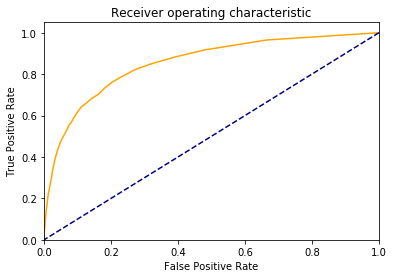

In [30]:
plt.plot(fpr_list, tpr_list, color="orange")
# set options here
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.plot(fpr_list, fpr_list, color="navy", linestyle="--")
plt.show()

### AUC calculation

- auc = P / (N +P)

In [46]:
positive = prediction_df.loc[prediction_df["SeriousDlqin2yrs"] == 1]
negative = prediction_df.loc[prediction_df["SeriousDlqin2yrs"] == 0]

positive_over_negative = 0
total_number = 0

for positive_value in positive["1 probability"]:
    for negative_value in negative["1 probability"]:
        if positive_value > negative_value:
            positive_over_negative += 1
        total_number += 1

auc = positive_over_negative / total_number
print(auc)

0.8555945470610585
